<a href="https://colab.research.google.com/github/buwituze/pre-consultation-agent/blob/main/typhoid_model_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Typhoid Fever Prediction Model
## Pre-consultation and triage Assistant

This notebook trains a machine learning model that take the patient's symptoms and history and predict if they have typhoid fever and the severity status.

**Model Performance:** 89.5% accuracy  
**Training Dataset:** 31,087 patients  
**Algorithm:** Gradient Boosting Classifier

## 1. Install & Import Dependencies

In [ ]:
# Install required packages (if needed)
# !pip install -q pandas numpy scikit-learn

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pickle
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 2. Mount Google Drive & Set Paths

This will mount your Google Drive and set up paths to access your dataset and save the model.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("✅ Google Drive mounted successfully")

Mounted at /content/drive
✅ Google Drive mounted successfully


In [ ]:
# Set paths
import os

# Path to your capstone folder
capstone_folder = '/content/drive/MyDrive/capstone-ML'

# Dataset path
dataset_path = os.path.join(capstone_folder, 'Typhoid_dataset.csv')

# Model save path
model_path = os.path.join(capstone_folder, 'typhoid_model.pkl')

# Verify dataset exists
if os.path.exists(dataset_path):
    print(f"✅ Dataset found: {dataset_path}")
else:
    print(f"❌ Dataset not found at: {dataset_path}")
    print("Please ensure 'Typhoid_dataset.csv' is in your 'My Drive/capstone-ML' folder")

✅ Dataset found: /content/drive/MyDrive/capstone-ML/Typhoid_dataset.csv


## 3. Define TyphoidPredictor Class

In [ ]:
class TyphoidPredictor:
    """
    Typhoid Fever Prediction Model
    Predicts typhoid status using clinical symptoms and patient history
    """

    def __init__(self):
        self.model = None
        self.label_encoders = {}
        self.scaler = StandardScaler()

        # Features used for prediction (no lab results)
        self.feature_columns = [
            'Age', 'Gender', 'Location', 'Socioeconomic Status',
            'Water Source Type', 'Sanitation Facilities', 'Hand Hygiene',
            'Consumption of Street Food', 'Fever Duration (Days)',
            'Gastrointestinal Symptoms', 'Neurological Symptoms',
            'Skin Manifestations', 'Complications',
            'Typhoid Vaccination Status', 'Previous History of Typhoid',
            'Weather Condition', 'Ongoing Infection in Society'
        ]

        self.target_column = 'Typhoid Status'

    def load_and_preprocess_data(self, filepath):
        """Load and preprocess the dataset"""
        df = pd.read_csv(filepath)

        # Select only needed features
        columns_to_use = self.feature_columns + [self.target_column]
        df = df[columns_to_use].copy()

        # Handle missing values (missing symptoms = "None")
        df['Gastrointestinal Symptoms'].fillna('None', inplace=True)
        df['Neurological Symptoms'].fillna('None', inplace=True)
        df['Complications'].fillna('None', inplace=True)
        df['Ongoing Infection in Society'].fillna('None', inplace=True)

        return df

    def encode_features(self, df, is_training=True):
        """Encode categorical features using Label Encoding"""
        df_encoded = df.copy()

        categorical_columns = [
            'Gender', 'Location', 'Socioeconomic Status',
            'Water Source Type', 'Sanitation Facilities', 'Hand Hygiene',
            'Consumption of Street Food', 'Gastrointestinal Symptoms',
            'Neurological Symptoms', 'Skin Manifestations', 'Complications',
            'Typhoid Vaccination Status', 'Previous History of Typhoid',
            'Weather Condition', 'Ongoing Infection in Society'
        ]

        for col in categorical_columns:
            if is_training:
                self.label_encoders[col] = LabelEncoder()
                df_encoded[col] = self.label_encoders[col].fit_transform(df_encoded[col])
            else:
                # Handle unseen categories during prediction
                df_encoded[col] = df_encoded[col].apply(
                    lambda x: x if x in self.label_encoders[col].classes_
                    else self.label_encoders[col].classes_[0]
                )
                df_encoded[col] = self.label_encoders[col].transform(df_encoded[col])

        return df_encoded

    def train_model(self, filepath, verbose=True):
        """Train the typhoid prediction model"""
        # Load and preprocess data
        df = self.load_and_preprocess_data(filepath)

        if verbose:
            print(f"Dataset shape: {df.shape}")
            print(f"Target distribution:\n{df[self.target_column].value_counts()}")

        # Encode features
        df_encoded = self.encode_features(df, is_training=True)

        # Split features and target
        X = df_encoded[self.feature_columns]
        y = df_encoded[self.target_column]

        # Encode target labels
        self.target_encoder = LabelEncoder()
        y_encoded = self.target_encoder.fit_transform(y)

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )

        # Scale numerical features
        self.scaler.fit(X_train[['Age', 'Fever Duration (Days)']])
        X_train[['Age', 'Fever Duration (Days)']] = self.scaler.transform(
            X_train[['Age', 'Fever Duration (Days)']]
        )
        X_test[['Age', 'Fever Duration (Days)']] = self.scaler.transform(
            X_test[['Age', 'Fever Duration (Days)']]
        )

        # Train Gradient Boosting model
        self.model = GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=5,
            random_state=42,
            verbose=0
        )

        if verbose:
            print("\n⏳ Training model...")

        self.model.fit(X_train, y_train)

        # Evaluate
        y_pred = self.model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        if verbose:
            print(f"✅ Training complete! Accuracy: {accuracy:.4f}")

        # Store evaluation data
        self.evaluation_data = {
            'y_test': y_test,
            'y_pred': y_pred,
            'accuracy': accuracy
        }

        return self.model

    def get_evaluation_report(self):
        """Get detailed evaluation metrics"""
        if not hasattr(self, 'evaluation_data'):
            return "Model not trained yet. Call train_model() first."

        y_test = self.evaluation_data['y_test']
        y_pred = self.evaluation_data['y_pred']

        print("="*70)
        print("MODEL EVALUATION REPORT")
        print("="*70)
        print(f"\nOverall Accuracy: {self.evaluation_data['accuracy']:.4f}")
        print("\nClassification Report:")
        print(classification_report(
            y_test, y_pred,
            target_names=self.target_encoder.classes_,
            zero_division=0
        ))

        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': self.feature_columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("\nTop 10 Most Important Features:")
        print(feature_importance.head(10).to_string(index=False))

        return feature_importance

    def predict_with_probabilities(self, patient_data):
        """
        Predict typhoid status with probability scores

        Args:
            patient_data (dict): Patient information

        Returns:
            dict: Prediction results with probabilities and risk assessment
        """
        # Create dataframe
        df = pd.DataFrame([patient_data])

        # Handle missing values
        df['Gastrointestinal Symptoms'].fillna('None', inplace=True)
        df['Neurological Symptoms'].fillna('None', inplace=True)
        df['Complications'].fillna('None', inplace=True)
        df['Ongoing Infection in Society'].fillna('None', inplace=True)

        # Encode and scale
        df_encoded = self.encode_features(df, is_training=False)
        df_encoded[['Age', 'Fever Duration (Days)']] = self.scaler.transform(
            df_encoded[['Age', 'Fever Duration (Days)']]
        )

        # Predict
        X = df_encoded[self.feature_columns]
        prediction = self.model.predict(X)[0]
        probabilities = self.model.predict_proba(X)[0]

        # Get prediction label
        prediction_label = self.target_encoder.inverse_transform([prediction])[0]

        # Create probability dictionary
        prob_dict = {
            class_name: probabilities[idx] * 100
            for idx, class_name in enumerate(self.target_encoder.classes_)
        }

        # Calculate severity risk
        severity_risk = self._calculate_severity_risk(prob_dict, patient_data)

        return {
            'prediction': prediction_label,
            'probabilities': prob_dict,
            'severity_risk_percentage': severity_risk,
            'confidence': max(probabilities) * 100
        }

    def _calculate_severity_risk(self, prob_dict, patient_data):
        """Calculate overall severity risk percentage"""
        # Base risk from probabilities
        typhoid_risk = (
            prob_dict.get('Acute Typhoid Fever', 0) * 0.5 +
            prob_dict.get('Relapsing Typhoid', 0) * 0.7 +
            prob_dict.get('Complicated Typhoid', 0) * 1.0
        )

        # Adjust based on clinical factors
        if patient_data.get('Fever Duration (Days)', 0) > 7:
            typhoid_risk *= 1.2

        if patient_data.get('Complications') not in [None, 'None', np.nan]:
            typhoid_risk *= 1.3

        if patient_data.get('Previous History of Typhoid') == 'Yes':
            typhoid_risk *= 1.1

        return min(typhoid_risk, 100)  # Cap at 100%

    def save_model(self, filepath='typhoid_model.pkl'):
        """Save trained model to file"""
        model_data = {
            'model': self.model,
            'label_encoders': self.label_encoders,
            'target_encoder': self.target_encoder,
            'scaler': self.scaler,
            'feature_columns': self.feature_columns
        }

        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)

        print(f"✅ Model saved to {filepath}")

    def load_model(self, filepath='typhoid_model.pkl'):
        """Load trained model from file"""
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)

        self.model = model_data['model']
        self.label_encoders = model_data['label_encoders']
        self.target_encoder = model_data['target_encoder']
        self.scaler = model_data['scaler']
        self.feature_columns = model_data['feature_columns']

        print("✅ Model loaded successfully")

print("✅ TyphoidPredictor class defined")

✅ TyphoidPredictor class defined


## 4. Load and Explore Dataset

In [ ]:
# Load dataset
df = pd.read_csv(dataset_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (31087, 23)

Columns: ['Age', 'Gender', 'Location', 'Socioeconomic Status', 'Water Source Type', 'Sanitation Facilities', 'Hand Hygiene', 'Consumption of Street Food', 'Fever Duration (Days)', 'Gastrointestinal Symptoms', 'Neurological Symptoms', 'Skin Manifestations', 'Complications', 'White Blood Cell Count', 'Platelet Count', 'Blood Culture Result', 'Widal Test', 'Typhidot Test', 'Typhoid Vaccination Status', 'Previous History of Typhoid', 'Weather Condition', 'Ongoing Infection in Society', 'Typhoid Status']

First few rows:


,Age,Gender,Location,Socioeconomic Status,Water Source Type,Sanitation Facilities,Hand Hygiene,Consumption of Street Food,Fever Duration (Days),Gastrointestinal Symptoms,...,White Blood Cell Count,Platelet Count,Blood Culture Result,Widal Test,Typhidot Test,Typhoid Vaccination Status,Previous History of Typhoid,Weather Condition,Ongoing Infection in Society,Typhoid Status
0,37,Female,Endemic,High,Untreated Supply,Proper,Yes,No,0,Diarrhea,...,3446,300334,Negative,High O & H Antibody,IgG Positive,Received,Yes,Hot & Dry,Dengue Outbreak,Normal or No Typhoid
1,26,Male,Endemic,Middle,Tap,Proper,Yes,No,16,Constipation,...,8002,158635,Positive,High O & H Antibody,Negative,Not Received,Yes,Rainy & Wet,Dengue Outbreak,Relapsing Typhoid
2,79,Female,Urban,Middle,Untreated Supply,Open Defecation,No,No,17,NaN,...,16488,193736,Positive,Low O & H Antibody,Negative,Received,No,Hot & Dry,COVID-19 Surge,Complicated Typhoid
3,9,Female,Endemic,High,River,Proper,No,No,0,Constipation,...,6390,283273,Negative,High O & H Antibody,Negative,Not Received,Yes,Hot & Dry,COVID-19 Surge,Normal or No Typhoid
4,32,Male,Urban,High,Untreated Supply,Proper,No,Yes,13,Diarrhea,...,10399,241089,Positive,Low O & H Antibody,Negative,Not Received,Yes,Moderate,Dengue Outbreak,Relapsing Typhoid


In [ ]:
# Check target distribution
print("Typhoid Status Distribution:")
print(df['Typhoid Status'].value_counts())
print(f"\nPercentages:")
print(df['Typhoid Status'].value_counts(normalize=True) * 100)

Typhoid Status Distribution:
Typhoid Status
Normal or No Typhoid    21701
Acute Typhoid Fever      5649
Relapsing Typhoid        2486
Complicated Typhoid      1251
Name: count, dtype: int64

Percentages:
Typhoid Status
Normal or No Typhoid    69.807315
Acute Typhoid Fever     18.171583
Relapsing Typhoid        7.996912
Complicated Typhoid      4.024190
Name: proportion, dtype: float64


In [ ]:
# Check for missing values
missing = df.isnull().sum()
missing_df = missing[missing > 0]

if len(missing_df) > 0:
    print("Columns with missing values:")
    print(missing_df)
else:
    print("✅ No missing values (after preprocessing)")

Columns with missing values:
Gastrointestinal Symptoms        7760
Neurological Symptoms            7744
Complications                   30147
Ongoing Infection in Society     7680
dtype: int64


## 5. Train the Model

In [ ]:
# Initialize predictor
predictor = TyphoidPredictor()

# Train model
predictor.train_model(dataset_path, verbose=True)

Dataset shape: (31087, 18)
Target distribution:
Typhoid Status
Normal or No Typhoid    21701
Acute Typhoid Fever      5649
Relapsing Typhoid        2486
Complicated Typhoid      1251
Name: count, dtype: int64

⏳ Training model...
✅ Training complete! Accuracy: 0.8953


GradientBoostingClassifier(max_depth=5, n_estimators=200, random_state=42)

## 6. Evaluate Model Performance

In [ ]:
# Get detailed evaluation report
feature_importance = predictor.get_evaluation_report()

MODEL EVALUATION REPORT

Overall Accuracy: 0.8953

Classification Report:
                      precision    recall  f1-score   support

 Acute Typhoid Fever       0.67      0.88      0.76      1130
 Complicated Typhoid       0.99      0.74      0.84       250
Normal or No Typhoid       0.99      1.00      0.99      4341
   Relapsing Typhoid       0.33      0.10      0.15       497

            accuracy                           0.90      6218
           macro avg       0.74      0.68      0.69      6218
        weighted avg       0.88      0.90      0.88      6218


Top 10 Most Important Features:
                     feature  importance
       Fever Duration (Days)    0.808393
               Complications    0.117014
                         Age    0.022388
   Gastrointestinal Symptoms    0.006843
           Weather Condition    0.006342
Ongoing Infection in Society    0.005452
           Water Source Type    0.005312
       Neurological Symptoms    0.004920
        Socioeconomic Sta

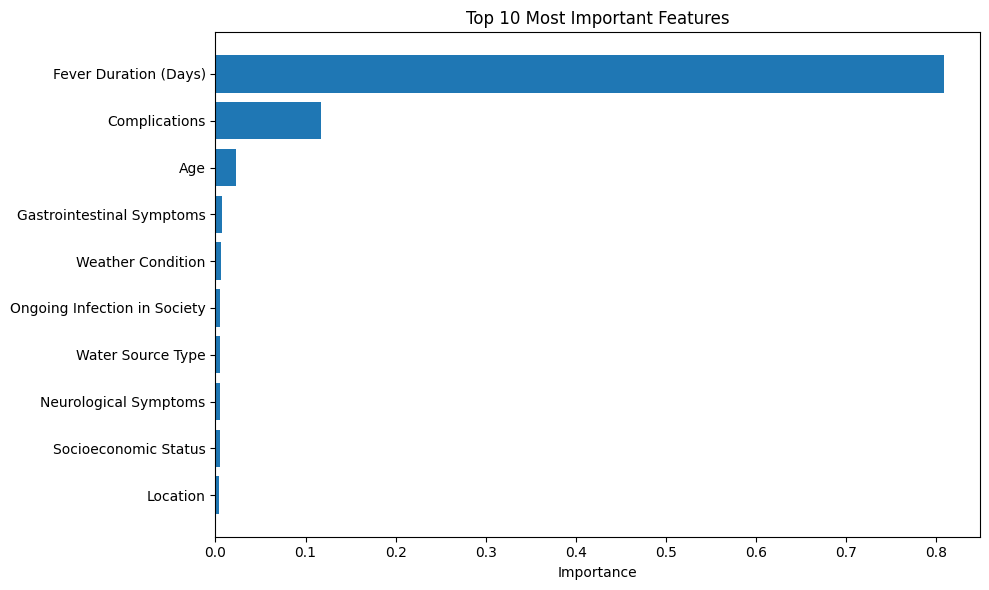

In [ ]:
# Visualize feature importance
import matplotlib.pyplot as plt

top_features = feature_importance.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Test Predictions with Examples

In [ ]:
# Example 1: Healthy patient (low risk)
healthy_patient = {
    "Age": 28,
    "Gender": "Female",
    "Location": "Urban",
    "Socioeconomic Status": "Middle",
    "Water Source Type": "Tap",
    "Sanitation Facilities": "Proper",
    "Hand Hygiene": "Yes",
    "Consumption of Street Food": "No",
    "Fever Duration (Days)": 0,
    "Gastrointestinal Symptoms": "None",
    "Neurological Symptoms": "None",
    "Skin Manifestations": "No",
    "Complications": "None",
    "Typhoid Vaccination Status": "Received",
    "Previous History of Typhoid": "No",
    "Weather Condition": "Moderate",
    "Ongoing Infection in Society": "None"
}

result = predictor.predict_with_probabilities(healthy_patient)

print("Example 1: Healthy Patient")
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.1f}%")
print(f"Severity Risk: {result['severity_risk_percentage']:.1f}%")

Example 1: Healthy Patient
Prediction: Normal or No Typhoid
Confidence: 98.1%
Severity Risk: 1.1%


In [ ]:
# Example 2: High-risk patient
high_risk_patient = {
    "Age": 35,
    "Gender": "Male",
    "Location": "Endemic",
    "Socioeconomic Status": "Low",
    "Water Source Type": "Untreated Supply",
    "Sanitation Facilities": "Open Defecation",
    "Hand Hygiene": "No",
    "Consumption of Street Food": "Yes",
    "Fever Duration (Days)": 14,
    "Gastrointestinal Symptoms": "Diarrhea",
    "Neurological Symptoms": "Headache",
    "Skin Manifestations": "Yes",
    "Complications": "None",
    "Typhoid Vaccination Status": "Not Received",
    "Previous History of Typhoid": "Yes",
    "Weather Condition": "Hot & Dry",
    "Ongoing Infection in Society": "Dengue Outbreak"
}

result = predictor.predict_with_probabilities(high_risk_patient)

print("Example 2: High-Risk Patient")
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.1f}%")
print(f"Severity Risk: {result['severity_risk_percentage']:.1f}%")
print(f"\nProbability Breakdown:")
for condition, prob in sorted(result['probabilities'].items(), key=lambda x: x[1], reverse=True):
    print(f"  {condition}: {prob:.1f}%")

Example 2: High-Risk Patient
Prediction: Acute Typhoid Fever
Confidence: 72.4%
Severity Risk: 76.2%

Probability Breakdown:
  Acute Typhoid Fever: 72.4%
  Relapsing Typhoid: 20.2%
  Complicated Typhoid: 7.4%
  Normal or No Typhoid: 0.0%


In [ ]:
# Example 3: Critical patient
critical_patient = {
    "Age": 42,
    "Gender": "Male",
    "Location": "Rural",
    "Socioeconomic Status": "Low",
    "Water Source Type": "River",
    "Sanitation Facilities": "Open Defecation",
    "Hand Hygiene": "No",
    "Consumption of Street Food": "Yes",
    "Fever Duration (Days)": 18,
    "Gastrointestinal Symptoms": "Abdominal Pain",
    "Neurological Symptoms": "Confusion",
    "Skin Manifestations": "Yes",
    "Complications": "Sepsis",
    "Typhoid Vaccination Status": "Not Received",
    "Previous History of Typhoid": "No",
    "Weather Condition": "Rainy & Wet",
    "Ongoing Infection in Society": "None"
}

result = predictor.predict_with_probabilities(critical_patient)

print("Example 3: Critical Patient")
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.1f}%")
print(f"Severity Risk: {result['severity_risk_percentage']:.1f}%")

Example 3: Critical Patient
Prediction: Complicated Typhoid
Confidence: 99.9%
Severity Risk: 100.0%


## 8. Save the Trained Model to Google Drive

In [ ]:
# Save model to Google Drive
predictor.save_model(model_path)
print(f"\n📁 Model saved to: {model_path}")
print("You can access it anytime from your Google Drive!")

✅ Model saved to /content/drive/MyDrive/capstone-ML/typhoid_model.pkl

📁 Model saved to: /content/drive/MyDrive/capstone-ML/typhoid_model.pkl
You can access it anytime from your Google Drive!


## 9. Load and Test Saved Model (Optional)

This cell verifies that the model was saved correctly by loading it from Google Drive.

In [ ]:
# Load the saved model from Google Drive
new_predictor = TyphoidPredictor()
new_predictor.load_model(model_path)

# Test with a patient
test_result = new_predictor.predict_with_probabilities(healthy_patient)
print(f"\nTest Prediction: {test_result['prediction']}")
print(f"Confidence: {test_result['confidence']:.1f}%")
print("\n✅ Model loads and works correctly!")

✅ Model loaded successfully

Test Prediction: Normal or No Typhoid
Confidence: 98.1%

✅ Model loads and works correctly!


## 10. Optional: Download Model Locally

If you want to download the model to your computer, run this cell.

---

## Summary

**Model Performance:**
- Accuracy: ~89.5%
- Best for: Pre-consultation typhoid screening
- No lab results required

**Files Location:**
- Dataset: `My Drive/capstone/Typhoid_dataset.csv`
- Trained Model: `My Drive/capstone/typhoid_model.pkl`

**Next Steps:**
1. Your trained model is saved in your Google Drive
2. Access it anytime from `My Drive/capstone/typhoid_model.pkl`
3. Use it in your web/mobile application
4. Integrate with the conversational assistant or API

**Important:** This is a screening tool, not a diagnostic replacement. Always consult healthcare professionals for proper diagnosis and treatment.